In [9]:
import sqlite3
import pandas
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

conn = sqlite3.connect('db.sqlite3')
data = conn.execute("""
with data_time as (
select sum(value) as attendances, commune_id, date(data.year || '-' || (
    case data.cohort
        when 'Enero' then '01'
        when 'Febrero' then '02'
        when 'Marzo' then '03'
        when 'Abril' then '04'
        when 'Mayo' then '05'
        when 'Junio' then '06'
        when 'Julio' then '07'
        when 'Agosto' then '08'
        when 'Septiembre' then '09'
        when 'Octubre' then '10'
        when 'Noviembre' then '11'
        when 'Diciembre' then '12'
        else 1
    end) || '-01') as date
from data
join report on data.report_id = report.id
where report.description = 'Ingresos Programa de Salud Mental por mes y año'
group by date, commune_id
),
contaminant_time as (
select avg(concentration) as concentration, commune_id, date(datetime, 'unixepoch', 'start of month') as date
from contaminant
where contaminant.contaminant = 'SO2'
group by date, commune_id
)
select commune.name, contaminant_time.concentration, data_time.date, attendances * 10000 / commune.population from data_time
join contaminant_time on data_time.date = contaminant_time.date and data_time.commune_id = contaminant_time.commune_id
join commune on data_time.commune_id = commune.id
""").fetchall()

# drop unixtimestamp
data = pandas.DataFrame(data, columns=['commune', 'concentration', 'date', 'attendances'])
data.index = pandas.to_datetime(data['date'])
data = data.drop(columns=['date'])

# scale
scaler = StandardScaler()
data[['concentration']] = scaler.fit_transform(data[['concentration']])
data[['attendances']] = scaler.fit_transform(data[['attendances']])

data

,commune,concentration,attendances
date,,,
2018-01-01,LA CISTERNA,0.318082,0.301024
2018-01-01,PENALOLEN,-1.227433,0.614815
2018-01-01,PUENTE ALTO,0.839011,0.824010
2018-01-01,TALAGANTE,-1.602993,-0.849545
2018-02-01,LA CISTERNA,-1.384115,-0.640351
...,...,...,...
2024-04-01,LA CISTERNA,1.280945,1.137801
2024-04-01,PENALOLEN,0.998143,0.510218
2024-05-01,PENALOLEN,1.432024,0.614815


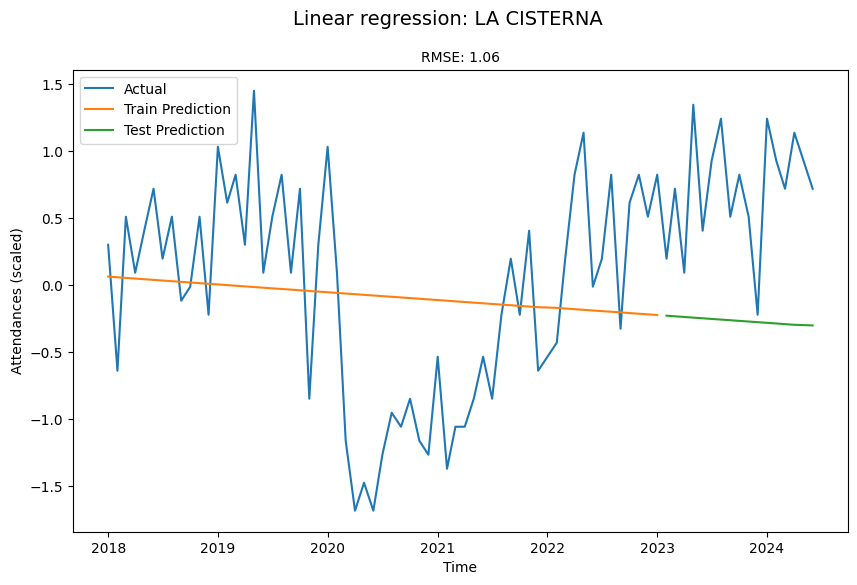

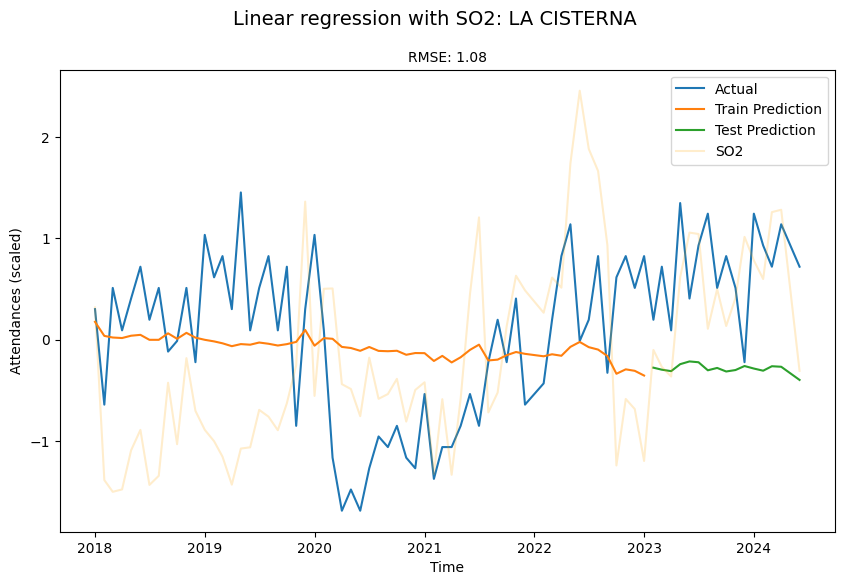

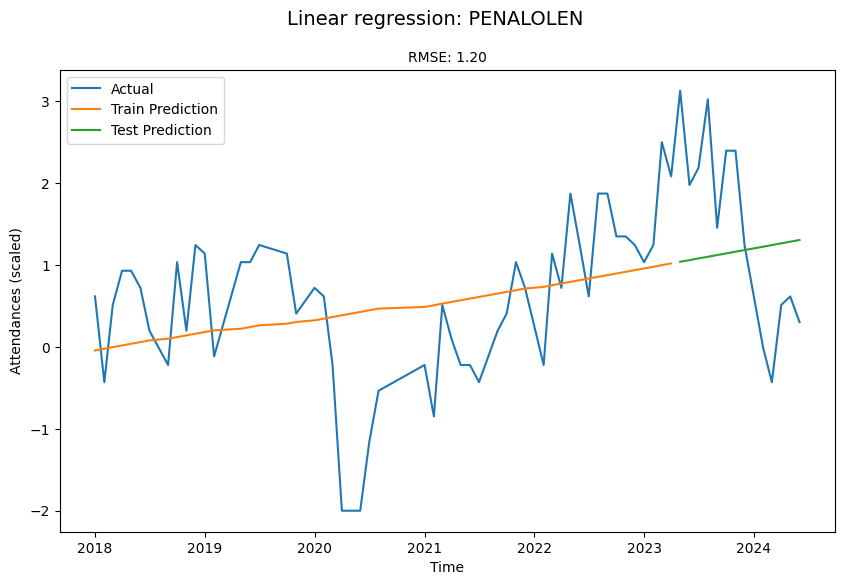

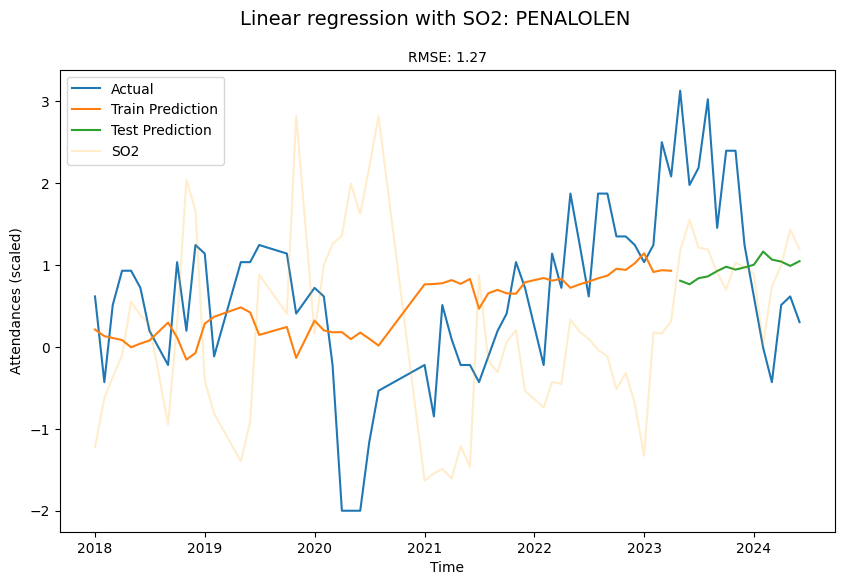

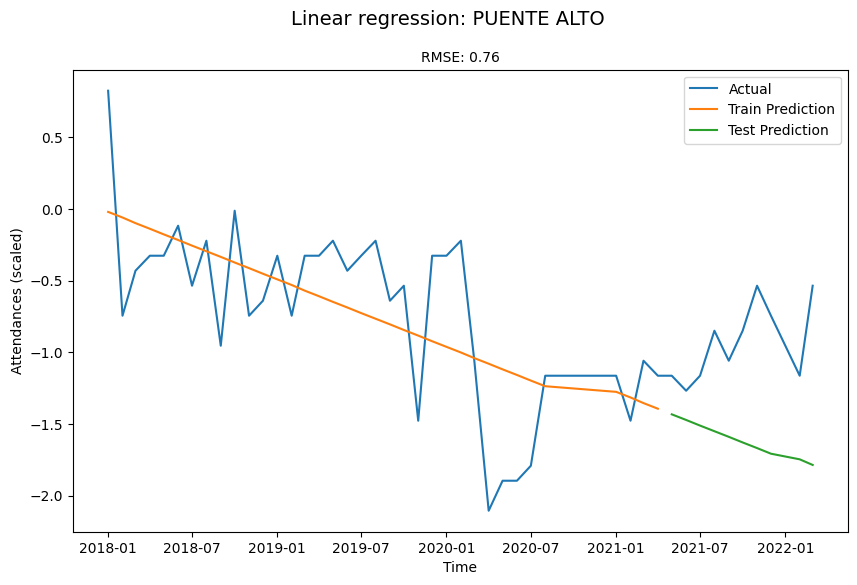

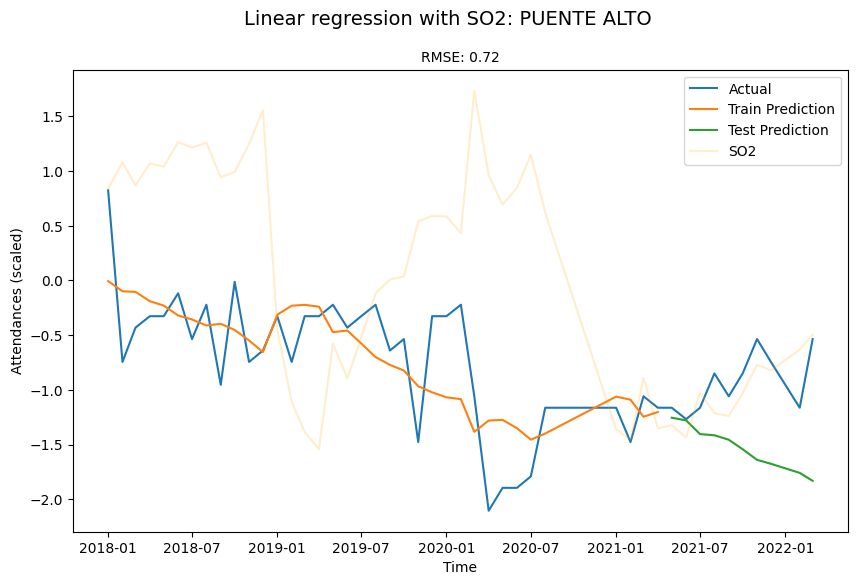

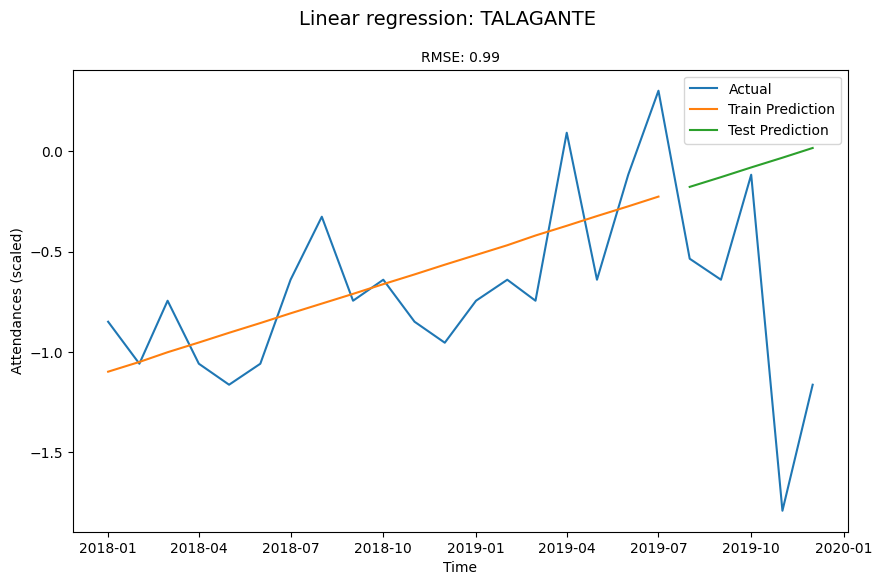

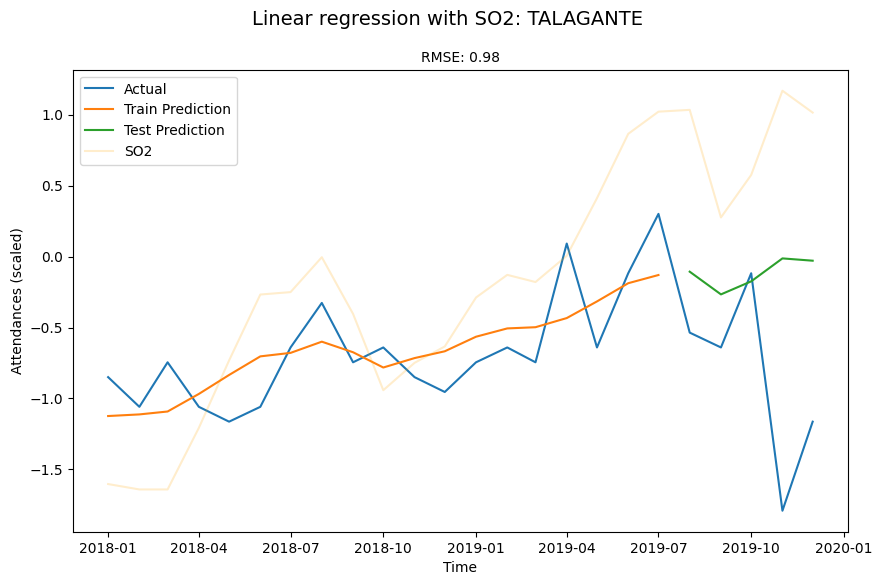

1.000939763523113
1.0106425648690736


In [16]:
rmse_list =[]
rmse_so2_list =[]
for commune in data['commune'].unique():
    # single commune no exog
    A = data[data['commune'] == commune][['attendances', 'concentration']]
    A['index'] = range(len(A))
    A_train, A_test = train_test_split(A, test_size=0.2, shuffle=False)

    # fit regression no exog
    model = LinearRegression()
    model.fit(A_train[['index']], A_train['attendances'])

    # predict
    A_train['predicted'] = model.predict(A_train[['index']])
    A_test['predicted'] = model.predict(A_test[['index']])

    # test RMSE
    rmse = root_mean_squared_error(A_test['attendances'], A_test['predicted'])
    rmse_list.append(rmse)

    # graph
    plt.figure(figsize=(10,6))
    plt.plot(A.index, A['attendances'], label='Actual')
    plt.plot(A_train.index, A_train['predicted'], label='Train Prediction')
    plt.plot(A_test.index, A_test['predicted'], label='Test Prediction')
    plt.legend()
    plt.suptitle(f'Linear regression: {commune}', fontsize=14)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Attendances (scaled)')
    plt.savefig(f'img/linear_{commune}.png')
    plt.show()

    # fit regression with exog
    model = LinearRegression()
    model.fit(A_train[['index', 'concentration']], A_train['attendances'])

    # predict
    A_test['predicted'] = model.predict(A_test[['index', 'concentration']])
    A_train['predicted'] = model.predict(A_train[['index', 'concentration']])

    # test RMSE
    rmse = root_mean_squared_error(A_test['attendances'], A_test['predicted'])
    rmse_so2_list.append(rmse)

    # graph
    plt.figure(figsize=(10,6))
    plt.plot(A.index, A['attendances'], label='Actual')
    plt.plot(A_train.index, A_train['predicted'], label='Train Prediction')
    plt.plot(A_test.index, A_test['predicted'], label='Test Prediction')
    plt.plot(A.index, A['concentration'], label='SO2', color='orange', alpha=0.2)
    plt.legend()
    plt.suptitle(f'Linear regression with SO2: {commune}', fontsize=14)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Attendances (scaled)')
    plt.savefig(f'img/linear_{commune}_so2.png')
    plt.show()

print(sum(rmse_list) / len(rmse_list))
print(sum(rmse_so2_list) / len(rmse_so2_list))

0.8657333113041604
0.8815544611328173


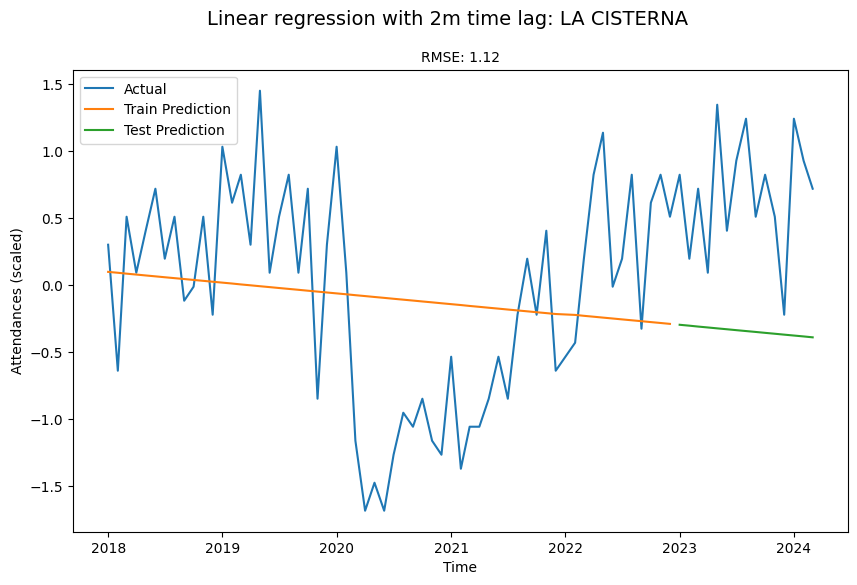

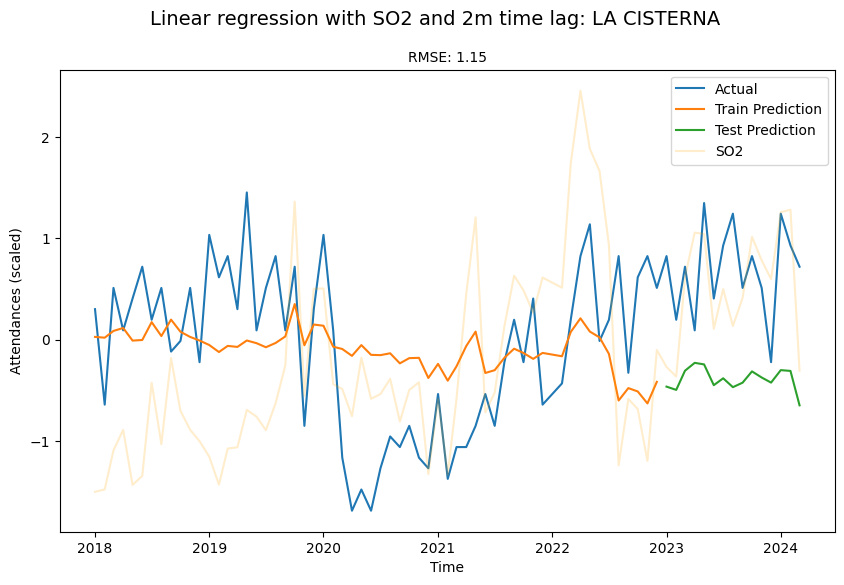

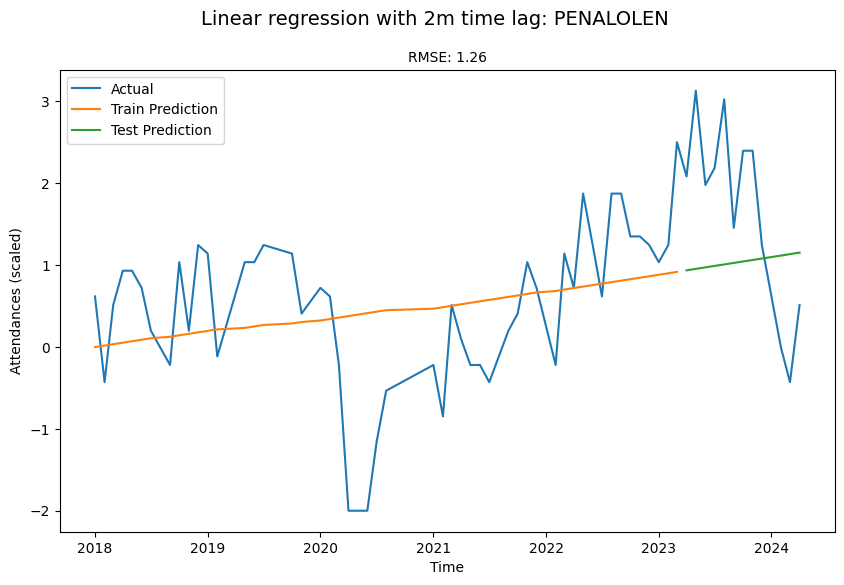

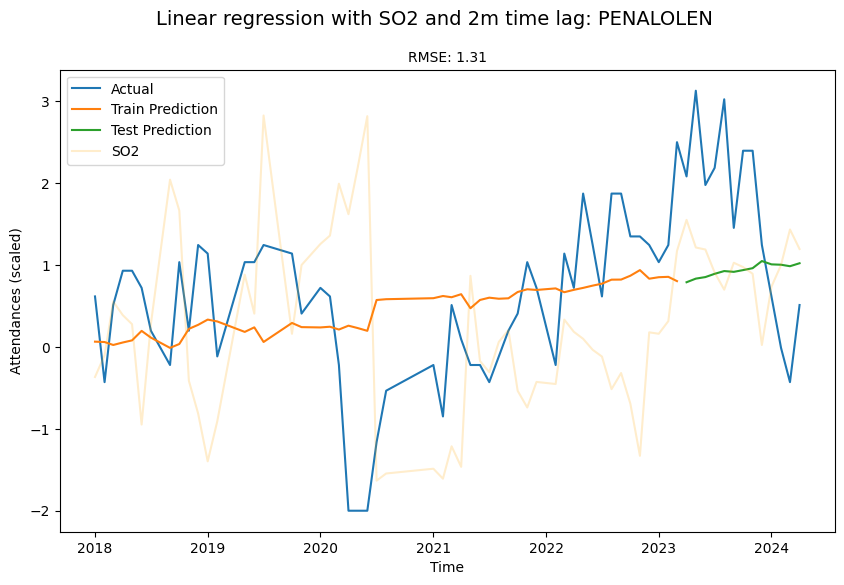

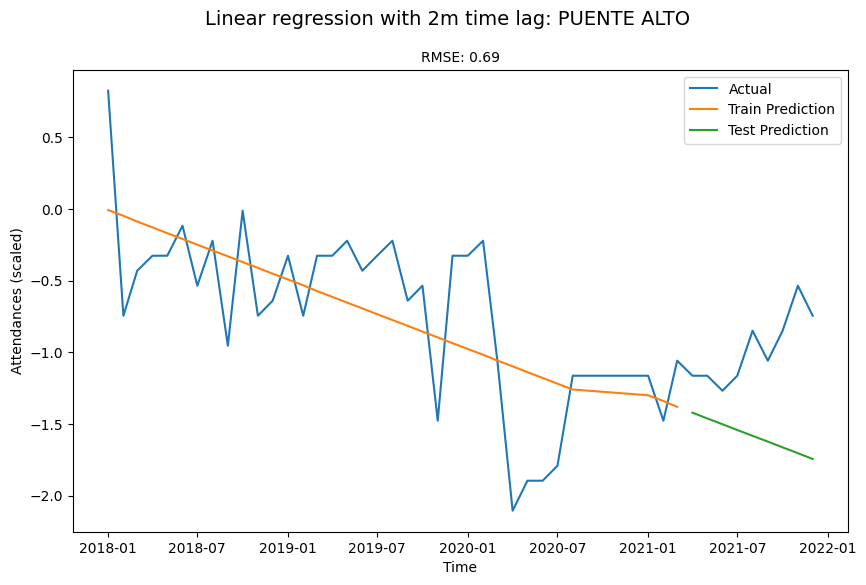

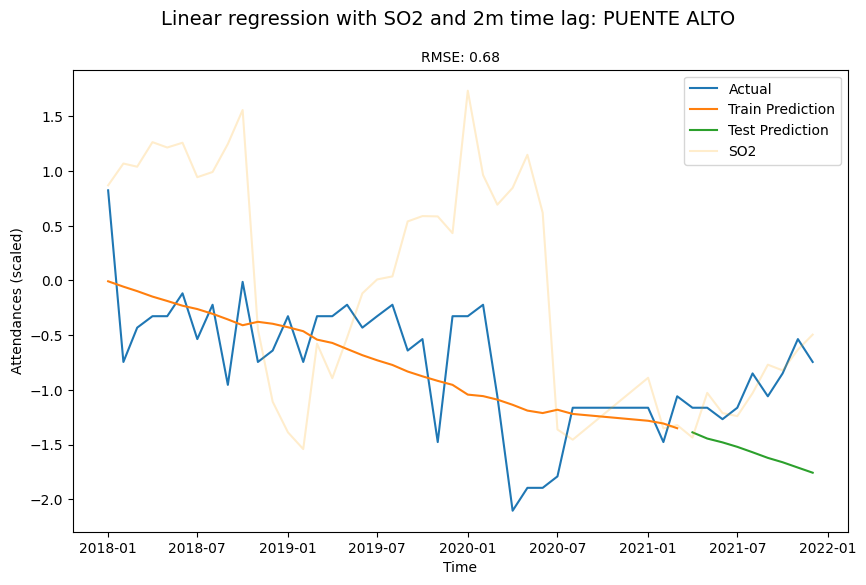

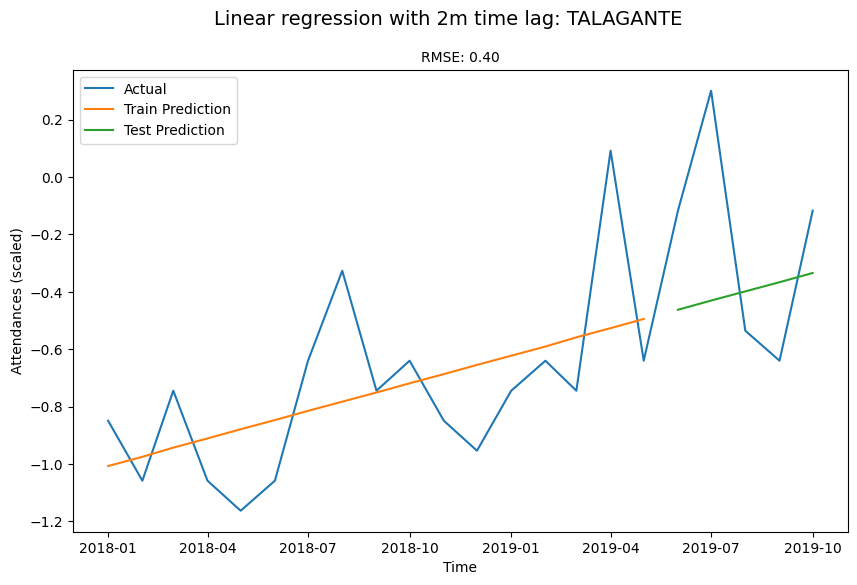

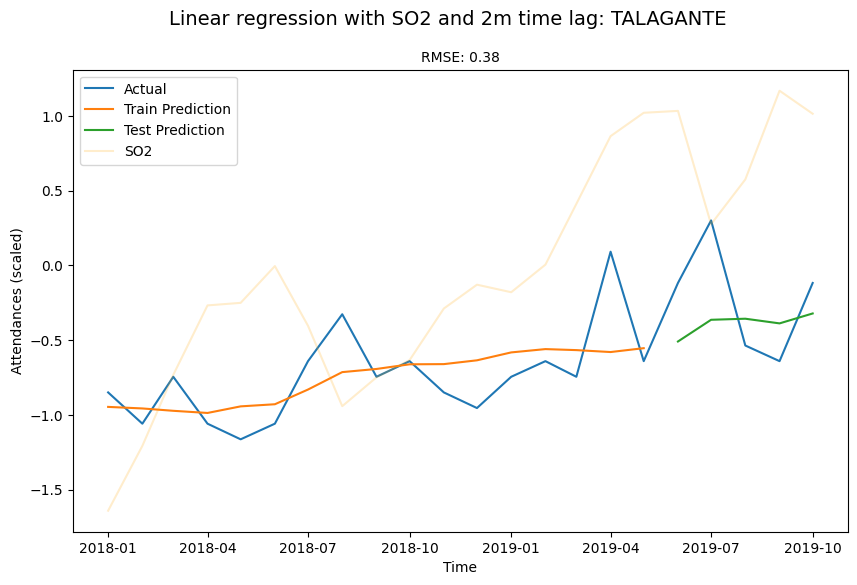

In [14]:
# with time lag
rmse_list =[]
rmse_so2_list =[]
for commune in data['commune'].unique():
    # single commune no exog
    A = data[data['commune'] == commune][['attendances', 'concentration']]
    A['index'] = range(len(A))
    # shift concentration 
    A['concentration'] = A['concentration'].shift(-2)
    A.dropna(inplace=True)

    A_train, A_test = train_test_split(A, test_size=0.2, shuffle=False)

    # fit regression no exog
    model = LinearRegression()
    model.fit(A_train[['index']], A_train['attendances'])

    # predict
    A_train['predicted'] = model.predict(A_train[['index']])
    A_test['predicted'] = model.predict(A_test[['index']])

    # test RMSE
    rmse = root_mean_squared_error(A_test['attendances'], A_test['predicted'])
    rmse_list.append(rmse)

    # graph
    plt.figure(figsize=(10,6))
    plt.plot(A.index, A['attendances'], label='Actual')
    plt.plot(A_train.index, A_train['predicted'], label='Train Prediction')
    plt.plot(A_test.index, A_test['predicted'], label='Test Prediction')
    plt.legend()
    plt.suptitle(f'Linear regression with 2m time lag: {commune}', fontsize=14)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Attendances (scaled)')

    # fit regression with exog
    model = LinearRegression()
    model.fit(A_train[['index', 'concentration']], A_train['attendances'])

    # predict
    A_test['predicted'] = model.predict(A_test[['index', 'concentration']])
    A_train['predicted'] = model.predict(A_train[['index', 'concentration']])

    # test RMSE
    rmse = root_mean_squared_error(A_test['attendances'], A_test['predicted'])
    rmse_so2_list.append(rmse)

    # graph
    plt.figure(figsize=(10,6))
    plt.plot(A.index, A['attendances'], label='Actual')
    plt.plot(A_train.index, A_train['predicted'], label='Train Prediction')
    plt.plot(A_test.index, A_test['predicted'], label='Test Prediction')
    plt.plot(A.index, A['concentration'], label='SO2', color='orange', alpha=0.2)
    plt.legend()
    plt.suptitle(f'Linear regression with SO2 and 2m time lag: {commune}', fontsize=14)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Attendances (scaled)')

print(sum(rmse_list) / len(rmse_list))
print(sum(rmse_so2_list) / len(rmse_so2_list))